# Libraries Import

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import spacy

df = pd.read_csv("../data/filter_dataset.csv")

C:\Users\Trushar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


# Training the BERT Classification Model

In [2]:
df = df[['Essay', 'Overall']].dropna()

# For Classification
def map_score_to_band(score):
    if score < 5.0:
        return 0
    elif score < 6.0:
        return 1
    elif score < 7.0:
        return 2
    elif score < 8.0:
        return 3
    else:
        return 4

df['Band'] = df['Overall'].apply(map_score_to_band)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Essay'].tolist(), df['Band'].tolist(), test_size=0.2, random_state=42
)

# Pretrained Model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
class EssayDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_texts, train_labels, tokenizer)
test_dataset = EssayDataset(test_texts, test_labels, tokenizer)

# BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5) # Classification

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
)


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.588600
20,1.491000
30,1.473800
40,1.432000
50,1.378800
60,1.518800
70,1.376700
80,1.413000
90,1.213600
100,1.318400


TrainOutput(global_step=240, training_loss=1.1666088024775187, metrics={'train_runtime': 311.8916, 'train_samples_per_second': 6.098, 'train_steps_per_second': 0.769, 'total_flos': 500450706966528.0, 'train_loss': 1.1666088024775187, 'epoch': 3.0})

# Saving the Pretrained Model

In [3]:
model.save_pretrained("./bert-band-model")
tokenizer.save_pretrained("./bert-band-model")


('./bert-band-model\\tokenizer_config.json',
 './bert-band-model\\special_tokens_map.json',
 './bert-band-model\\vocab.txt',
 './bert-band-model\\added_tokens.json')

# Loading the Pretrained Model for Evaluation

In [4]:
model = BertForSequenceClassification.from_pretrained("./bert-band-model")
tokenizer = BertTokenizer.from_pretrained("./bert-band-model")


# Evaluation

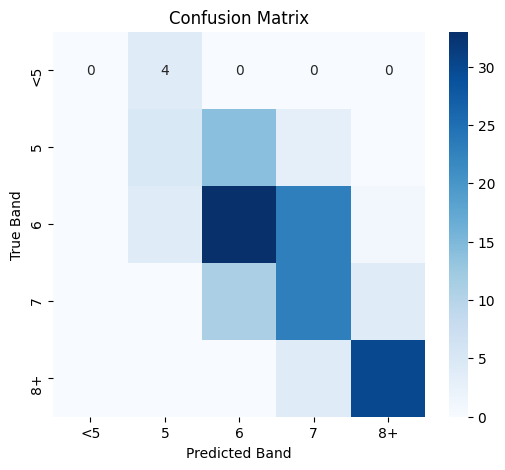

In [5]:
preds = trainer.predict(test_dataset)
predictions = np.argmax(preds.predictions, axis=1)
true = preds.label_ids

band_names = ["<5", "5", "6", "7", "8+"]

# Accuracy

# Confusion Matrix
cm = confusion_matrix(true, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=band_names, yticklabels=band_names)
plt.xlabel('Predicted Band')
plt.ylabel('True Band')
plt.title('Confusion Matrix')
plt.show()


# Feedback Generation

In [6]:
nlp = spacy.load("en_core_web_sm")

def generate_feedback(essay):
    feedback = []
    doc = nlp(essay)

    # Sentence length
    sentences = list(doc.sents)
    avg_len = sum(len(sent) for sent in sentences) / len(sentences)
    if avg_len < 12:
        feedback.append("Try to write longer and more detailed sentences.")

    # Lexical diversity
    words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    unique_words = set(words)
    diversity = len(unique_words) / (len(words) + 1e-5)
    if diversity < 0.4:
        feedback.append("Improve vocabulary by avoiding repetition.")

    # Linking words
    transitions = ["however", "therefore", "moreover", "for example"]
    if not any(t in essay.lower() for t in transitions):
        feedback.append("Add transition words (e.g., 'however', 'moreover') to improve coherence.")

    return feedback or ["Well-structured essay with good coherence and vocabulary."]

def predict_band_and_feedback(essay, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(essay, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model(**inputs)
    predicted_band = torch.argmax(outputs.logits, dim=1).item()

    band_map = {0: "<5", 1: "5", 2: "6", 3: "7", 4: "8+"}
    band = band_map[predicted_band]
    feedback = generate_feedback(essay)

    return band, feedback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

example_essay = df['Essay'].iloc[0] # taking the first essay from the dataset.
band, feedback = predict_band_and_feedback(example_essay, model, tokenizer, device)

print(f"Predicted Band: {band}")
print("Feedback:")
for f in feedback:
    print(f)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)